In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime,date,timedelta
from functions import *
mpl.rcParams["figure.dpi"] = 480
mpl.rcParams["figure.figsize"] = (10,6)
plt.style.use("ggplot")
spx = yf.Ticker("^SPX")
time_chain = list(map(lambda x:datetime.strptime(x, "%Y-%m-%d"),spx.options))

# Getting the risk free rate $r$ in one month

In [2]:
one_month_treasury = yf.Ticker("^IRX")  
history = one_month_treasury.history(period="10d")  
r = history["Close"].iloc[-1]*0.01
r

0.04938000202178955

# Getting the expiration

In [3]:
now = datetime.now()
formatted_date_str = now.strftime("%Y-%m-%d")
today = datetime.strptime(formatted_date_str, "%Y-%m-%d")
time_delta = now + timedelta(days=30)
ind = bisearch_right(time_chain, time_delta, lo=0, hi=None) # binary-searching the maturity
time_delta = time_chain[ind].strftime("%Y-%m-%d")
maturity = datetime.strptime(time_delta, "%Y-%m-%d")
T = abs((maturity - today).days)
T /= 365
T

0.09863013698630137

# Getting the option data

In [4]:
spx_options = spx.option_chain(time_delta)

In [5]:
calls = spx_options.calls[["contractSymbol","strike","lastPrice","bid","ask","volume"]]
puts = spx_options.puts[["contractSymbol","strike","lastPrice","bid","ask","volume"]]

# Step 1: Selecting options and calculating the forword price

## 1.1 Finding strike price $K_0$

In [6]:
call_df = spx_options.calls.loc[:,["strike","lastPrice"]]
put_df = spx_options.puts.loc[:,["strike","lastPrice"]]
merged = pd.merge(call_df,put_df,how = "inner",on="strike",suffixes = ["_call","_put"])
merged["diff"] = abs(merged["lastPrice_call"] - merged["lastPrice_put"]) 
merged = merged.iloc[::-1].reset_index()
k0,call_price,put_price = merged.iloc[merged["diff"].idxmin(),:][["strike","lastPrice_call","lastPrice_put"]].values
k0,call_price,put_price

(4160.0, 66.2, 68.8)

## 1.2 Calculating the forward price

In [7]:
F = k0 + np.exp(r*T)*(call_price-put_price)
F

4157.387306186849

## 1.3 Selecting OTM puts and calls

In [8]:
cond1 = calls["strike"] > k0
cond2 = calls["ask"] > 0
cond3 = calls["bid"] > 0
cond4 = calls["ask"] / calls["bid"] < 2 
cond5 = calls["volume"] > 0
calls_OTM = calls[cond1 & cond2 & cond3 & cond4 & cond5]

In [9]:
cond1 = puts["strike"] <= k0
cond2 = puts["ask"] > 0
cond3 = puts["bid"] > 0
cond4 = puts["ask"] / puts["bid"] < 2 
cond5 = puts["volume"] > 0
puts_OTM = puts[cond1 & cond2 & cond3 & cond4 & cond5]

# Step 2: Calculating volatility

## Defining some functions

In [10]:
def d2(k,sigma):
    return -k/(sigma*np.sqrt(T)) - (sigma*np.sqrt(T))/2

def P_BS(k,sigma):
    d2_ = d2(k,sigma)
    d1 = d2_ + (sigma*np.sqrt(T))
    return F * np.exp(k) * norm.cdf(-d2_) - F * norm.cdf(-d1)

def P_implied_vol(k,price):
    obj_f = lambda sigma: P_BS(k,sigma) - price * np.exp(r*T)
    root = brentq(obj_f,0.01,1)
    return root

def C_BS(k,sigma):
    d2_ = d2(k,sigma)
    d1 = d2_ + (sigma*np.sqrt(T))
    return -F * np.exp(k) * norm.cdf(d2_) + F * norm.cdf(d1)

def C_implied_vol(k,price):
    obj_f = lambda sigma: C_BS(k,sigma) - price * np.exp(r*T)
    root = brentq(obj_f,0.01,1)
    return root

## 2.1 Converting the data

In [11]:
copy = calls_OTM.copy()
copy["imp_vol"] = copy.apply(lambda x:C_implied_vol(np.log(x["strike"]/F),(x["bid"]+x["ask"])/2),axis = 1)**2
copy["d2"] = copy.apply(lambda x: d2(np.log(x["strike"]/F),x["imp_vol"]**0.5),axis = 1)
calls_OTM = copy

In [12]:
copy = puts_OTM.copy()
copy["imp_vol"] = copy.apply(lambda x:P_implied_vol(np.log(x["strike"]/F),(x["bid"]+x["ask"])/2),axis = 1)**2
copy["d2"] = copy.apply(lambda x: d2(np.log(x["strike"]/F),x["imp_vol"]**0.5),axis = 1)
puts_OTM = copy

In [13]:
i,j = longest_dinterval(calls_OTM)
calls_OTM = calls_OTM.iloc[i:j+1,:]

In [14]:
i,j = longest_iinterval(puts_OTM)
puts_OTM = puts_OTM.iloc[i:j+1,:]

In [15]:
df_combine = pd.concat([puts_OTM,calls_OTM],axis = 0)
df_combine = df_combine.sort_values(by = "d2")
df_combine

,contractSymbol,strike,lastPrice,bid,ask,volume,imp_vol,d2
142,SPXW230526C04600000,4600.0,0.42,0.20,0.35,10.0,0.015702,-2.590462
141,SPXW230526C04500000,4500.0,1.00,0.65,0.80,21.0,0.012982,-2.230995
140,SPXW230526C04450000,4450.0,1.42,1.35,1.50,27.0,0.012272,-1.972417
139,SPXW230526C04425000,4425.0,2.92,2.00,2.20,2.0,0.012154,-1.819090
138,SPXW230526C04400000,4400.0,3.02,2.95,3.10,27.0,0.011990,-1.666527
...,...,...,...,...,...,...,...,...
10,SPXW230526P02900000,2900.0,0.75,0.75,0.90,76.0,0.201728,2.482921
9,SPXW230526P02800000,2800.0,0.67,0.60,0.70,2.0,0.227049,2.566531
8,SPXW230526P02700000,2700.0,0.50,0.45,0.60,5.0,0.255430,2.640054
7,SPXW230526P02600000,2600.0,0.35,0.35,0.50,14.0,0.286069,2.710358


## 2.2 Constructing a function approximating

In [16]:
x = df_combine["d2"]
y = df_combine["imp_vol"]
points = np.column_stack((x, y))
diff = np.diff(points,axis = 0,prepend = np.nan)
diff_x = diff[:,0]
diff_y = diff[:,1]

### Slope (coefficient b)

In [17]:
l_plus = np.sqrt((diff_x[2:]**2 + diff_y[2:]**2))
l = np.sqrt((diff_x[1:-1]**2 + diff_y[1:-1]**2))
numerator = diff_x[2:]/l_plus - diff_x[1:-1]/l
denominator = diff_y[2:]/l_plus - diff_y[1:-1]/l
b = -numerator/denominator
b = np.concatenate(([0],b,[0]))
df_combine["b"] = b

### coefficient c

In [18]:
c = (3*diff_y[1:] - diff_x[1:]*b[1:] - 2*diff_x[1:]*b[:-1])/diff_x[1:]**2
c = np.concatenate((c,[0]))
df_combine["c"] = c

### coefficient d

In [19]:
d = (diff_y[1:] - b[:-1]*diff_x[1:] - c[:-1]*diff_x[1:]**2)/diff_x[1:]**3
d = np.concatenate((d,[0]))
df_combine["d"] = d

In [20]:
df_combine

,contractSymbol,strike,lastPrice,bid,ask,volume,imp_vol,d2,b,c,d
142,SPXW230526C04600000,4600.0,0.42,0.20,0.35,10.0,0.015702,-2.590462,0.000000,-0.048815,0.077232
141,SPXW230526C04500000,4500.0,1.00,0.65,0.80,21.0,0.012982,-2.230995,-0.005156,0.014839,-0.021315
140,SPXW230526C04450000,4450.0,1.42,1.35,1.50,27.0,0.012272,-1.972417,-0.001757,0.013874,-0.048513
139,SPXW230526C04425000,4425.0,2.92,2.00,2.20,2.0,0.012154,-1.819090,-0.000924,-0.002940,0.012668
138,SPXW230526C04400000,4400.0,3.02,2.95,3.10,27.0,0.011990,-1.666527,-0.000937,-0.005015,0.115430
...,...,...,...,...,...,...,...,...,...,...,...
10,SPXW230526P02900000,2900.0,0.75,0.75,0.90,76.0,0.201728,2.482921,0.298311,-0.382634,5.224798
9,SPXW230526P02800000,2800.0,0.67,0.60,0.70,2.0,0.227049,2.566531,0.343901,0.810204,-3.227600
8,SPXW230526P02700000,2700.0,0.50,0.45,0.60,5.0,0.255430,2.640054,0.410697,1.116324,-10.798367
7,SPXW230526P02600000,2600.0,0.35,0.35,0.50,14.0,0.286069,2.710358,0.407544,1.991717,-13.273316


## 2.3 Function Construction

In [21]:
# sigma^2(d_2^{-1}(k))
def y(x): 
    if x<=df_combine["d2"].iloc[0]:
        return df_combine["imp_vol"].iloc[0]
    elif x>=df_combine["d2"].iloc[-1]:
        return df_combine["imp_vol"].iloc[-1]
    array = df_combine["d2"].values
    ind = np.searchsorted(array,x,side = "right")-1
    x_j = array[ind]
    a = df_combine["imp_vol"].values[ind]
    b = df_combine["b"].values[ind]
    c = df_combine["c"].values[ind]
    d = df_combine["d"].values[ind]
    return a+b*(x-x_j)+c*(x-x_j)**2+d*(x-x_j)**3

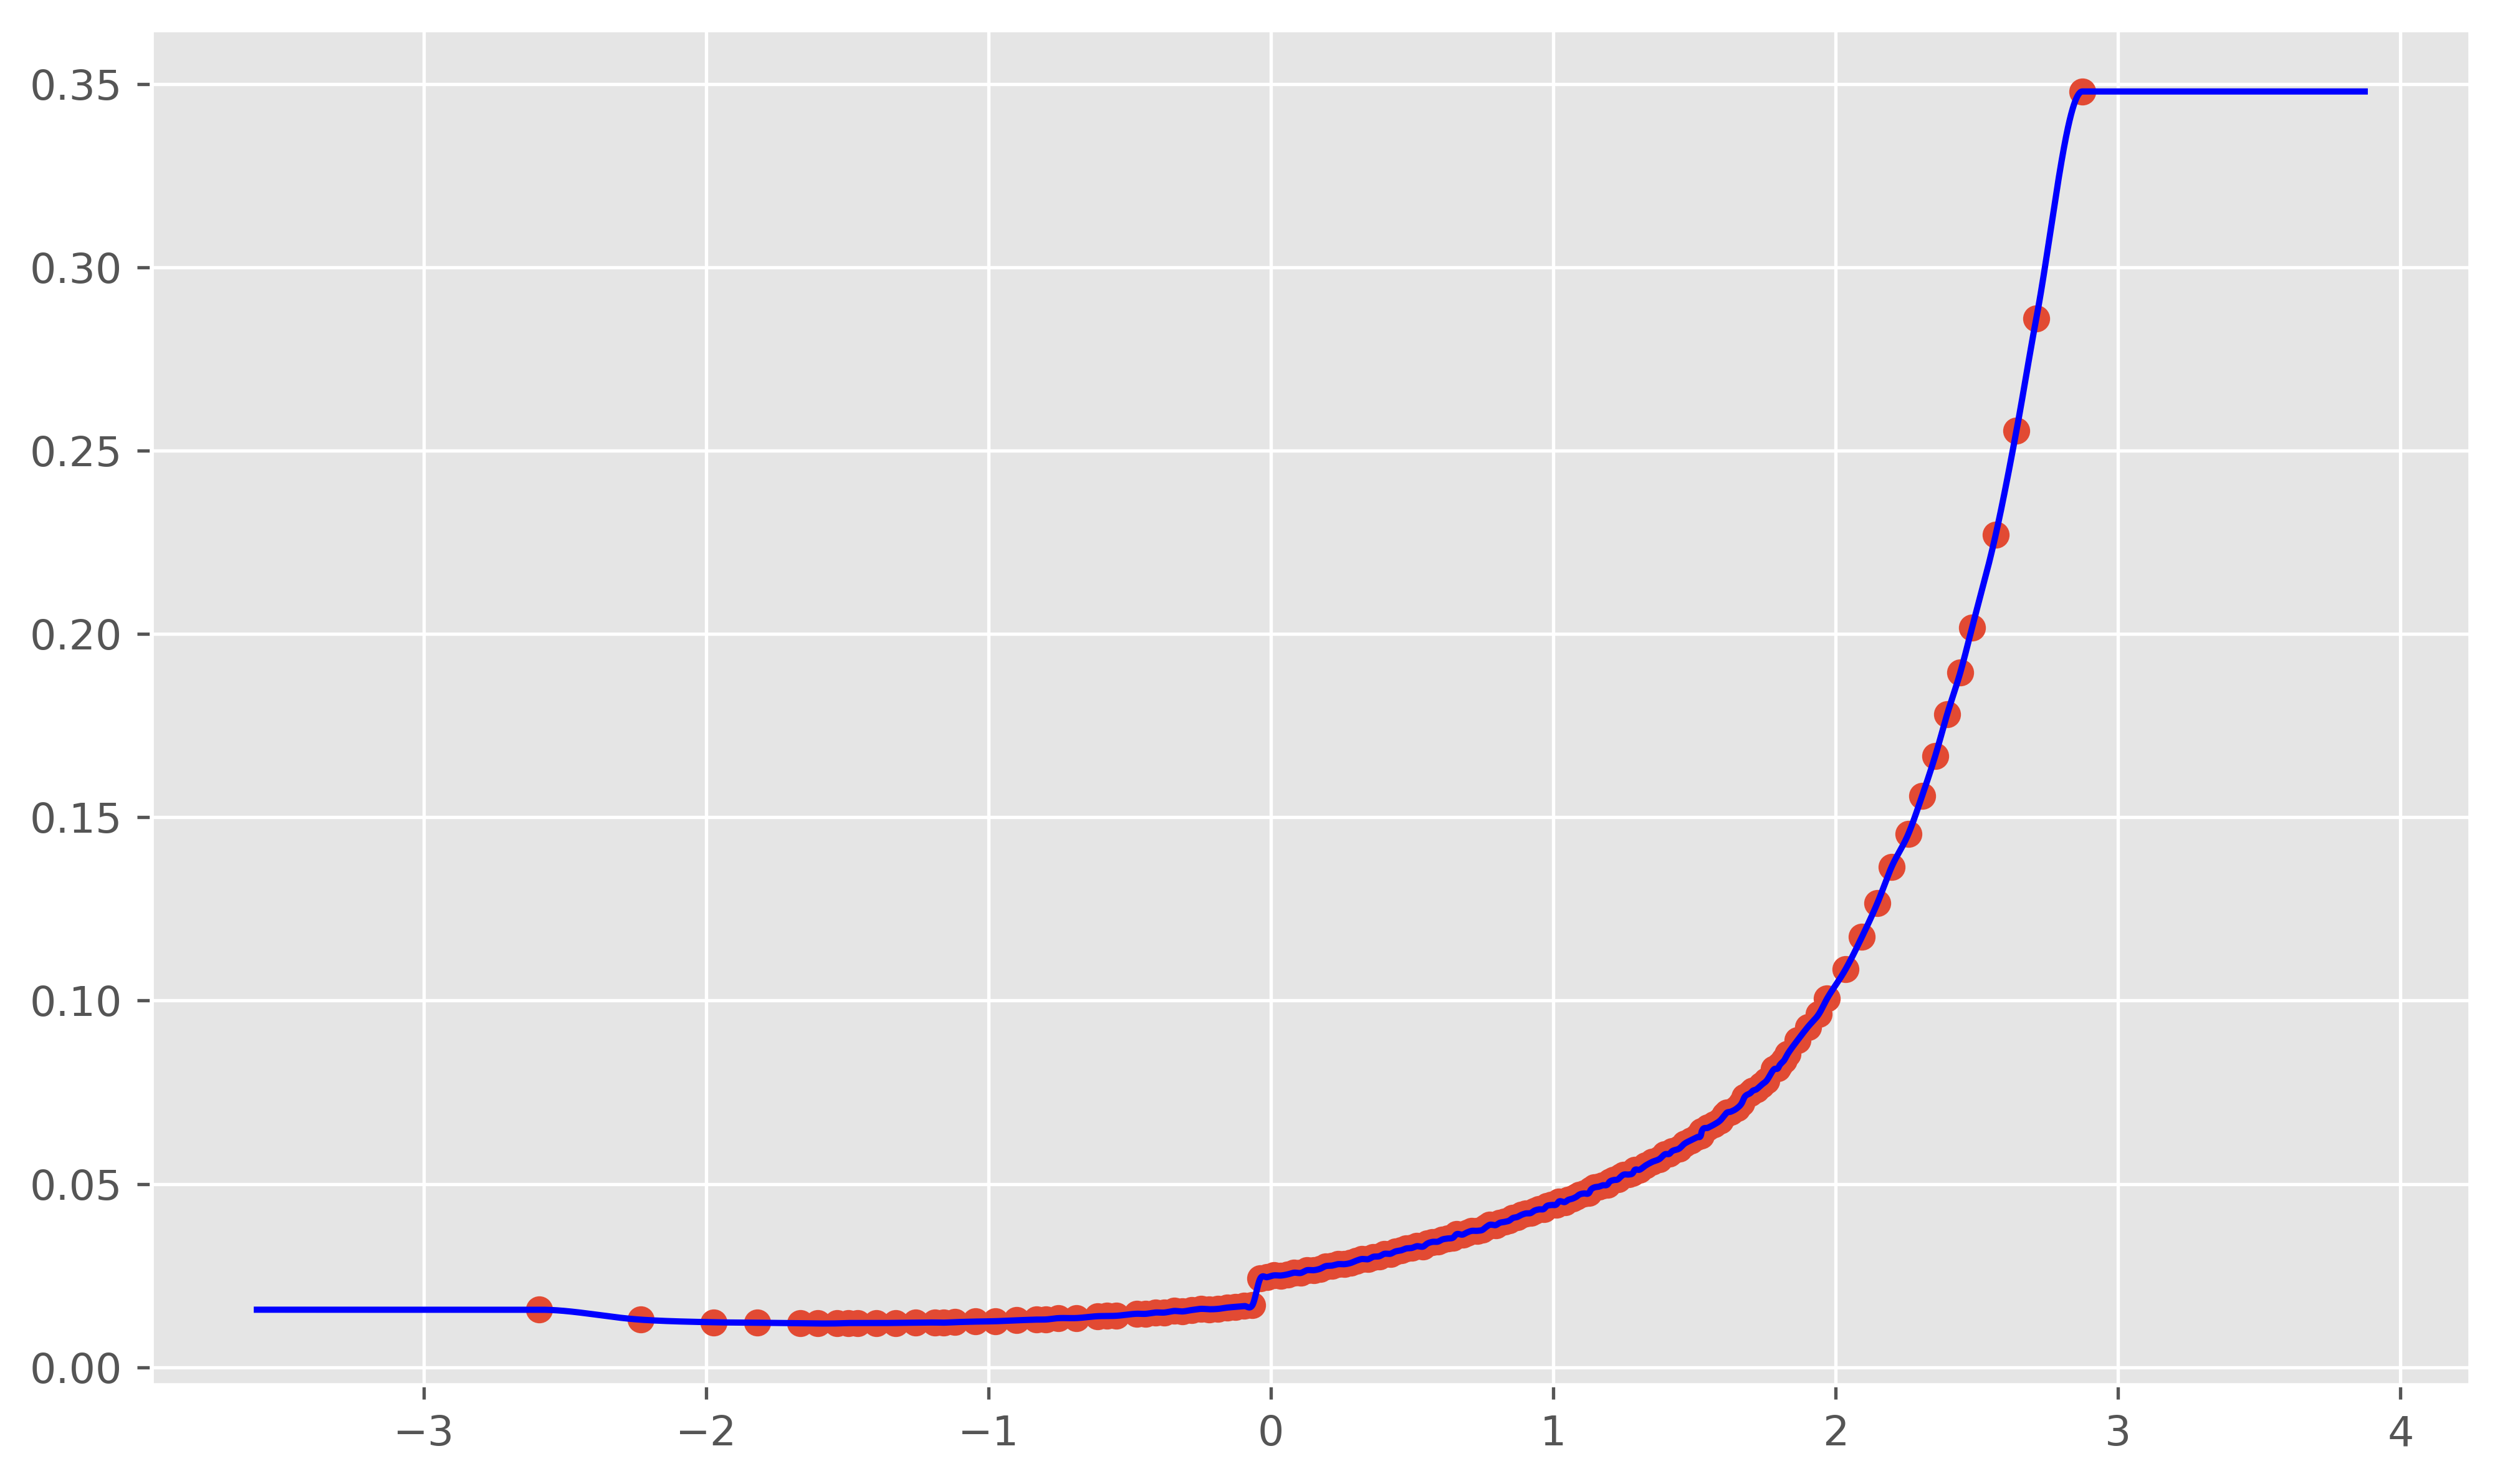

In [22]:
tmp_list = np.linspace(points[0,0]-1,points[-1,0]+1,10000)
plt.plot(tmp_list,[y(x) for x in tmp_list],"b-")
plt.scatter(points[:,0],points[:,1])

# STEP 3 Integrating

In [23]:
def integration():
    x = df_combine["d2"].values
    phi_plus = norm.pdf(x[1:])
    phi = norm.pdf(x[:-1])
    A = norm.cdf(x[1:]) - norm.cdf(x[:-1])
    B = -(phi_plus - phi) - x[:-1]*A
    C = (
        -(x[1:]*phi_plus-x[:-1]*phi) + 2*x[:-1]*(phi_plus-phi) + 
         (1+x[:-1]**2)*A
    )
    D = (
        (1-x[1:]**2)*phi_plus - (1-x[:-1]**2)*phi + 
        3*x[:-1]*(x[1:]*phi_plus - x[:-1]*phi) - 
        3*(1+x[:-1]**2)*(phi_plus-phi) - 
        x[:-1]*(3+x[:-1]**2)*A
    )
    a = df_combine["imp_vol"].values
    b = df_combine["b"].values
    c = df_combine["c"].values
    d = df_combine["d"].values
    part1 = np.sum(a[:-1] * A + b[:-1] * B + c[:-1] * C + d[:-1] * D)
    part2 = a[0] * norm.cdf(x[0]) + a[-1]*(1-norm.cdf(x[-1]))
    return part1 + part2
print(f"The implied volatility the list of options of maturity at {time_delta}, is {np.round(np.sqrt(integration()),6)*100}%.")

The implied volatility the list of options of maturity at 2023-05-26, is 17.4561%.


# IV of CBOE method

$$
\begin{aligned}
-2 \mathbb{E}\left[\log \left(S_T / F\right)\right] \approx & 2 \sum_{K=K_{\min }}^{K_0-1} \frac{P(K)}{K^2} \Delta K+\frac{P\left(K_0\right)+C\left(K_0\right)}{K_0^2} \Delta K_0 \\
& +2 \sum_{K=K_0+1}^{K_{\max }} \frac{C(K)}{K^2} \Delta K-\left(\frac{F}{K_0}-1\right)^2
\end{aligned}
$$
Denote:

$
T_1 = \sum_{K=K_{\min }}^{K_0-1} \frac{P(K)}{K^2} \Delta K
$

$
T_2 = \frac{P\left(K_0\right)+C\left(K_0\right)}{K_0^2} \Delta K_0
$

$
T_3 = \sum_{K=K_0+1}^{K_{\max }} \frac{C(K)}{K^2} \Delta K
$

$
T_4 = \left(\frac{F}{K_0}-1\right)^2
$

## Calculation of the first term

In [24]:
cond1 = puts["strike"] <= k0
cond2 = puts["ask"] > 0
cond3 = puts["bid"] > 0
cond4 = puts["volume"] > 0
puts_OTM_CBOE = puts[cond1 & cond2 & cond3 & cond4]

In [25]:
diff_k = puts_OTM_CBOE["strike"].diff().values
T_1 = np.sum((puts_OTM_CBOE["bid"].values[:-1] + puts_OTM_CBOE["ask"].values[:-1])/2 * np.exp(r*T)/(puts_OTM_CBOE["strike"].values[:-1]**2) * diff_k[1:])
T_1 -= (puts_OTM_CBOE["bid"].values[-2] + puts_OTM_CBOE["ask"].values[-2])/2 * np.exp(r*T)/(puts_OTM_CBOE["strike"].values[-2]**2)
T_1

0.0011563902496941779

In [26]:
cond1 = calls["strike"] >= k0
cond2 = calls["ask"] > 0
cond3 = calls["bid"] > 0
cond4 = calls["volume"] > 0
calls_OTM_CBOE = calls[cond1 & cond2 & cond3 & cond4]

In [27]:
diff_k = calls_OTM_CBOE["strike"].diff().values
T_3 = np.sum((calls_OTM_CBOE["bid"].values[1:] + calls_OTM_CBOE["ask"].values[1:])/2 * np.exp(r*T)/(calls_OTM_CBOE["strike"].values[1:]**2) * diff_k[1:])
T_3 -= (calls_OTM_CBOE["bid"].values[1] + calls_OTM_CBOE["ask"].values[1])/2 * np.exp(r*T)/(calls_OTM_CBOE["strike"].values[1]**2)
T_3

0.0003118418273140246

In [28]:
T_2 = (puts_OTM_CBOE["lastPrice"].values[-1] + calls_OTM_CBOE["lastPrice"].values[0])* np.exp(r*T) / (k0**2) * 2
T_2

1.567805818193878e-05

In [29]:
T_4 = (F/k0-1)**2
T_4

3.9444855776614696e-07

In [30]:
vix = (2*T_1 + T_2 + 2*T_3 - T_4)/T
vix**0.5

0.17299549879571458

### Formula for calculating VIX given by CBOE

In [31]:
def puts_(x):
    mid = (x["ask"].values + x["bid"].values)/2
    strike = x["strike"].values
    n = len(x)
    d = np.exp(r*T)
    ans = mid[0] * d * (strike[1]-strike[0])*0.5/strike[0]**2
    for i in range(1,n-1):
        ans += mid[i] * d * (strike[i+1]-strike[i-1])*0.5/strike[i]**2
    ans += mid[n-1] * d * (strike[n-1]-strike[n-2])*0.5/strike[n-1]**2
    return ans * 2


In [32]:
def calls_(x):
    mid = (x["ask"].values + x["bid"].values)/2
    strike = x["strike"].values
    n = len(x)
    d = np.exp(r*T)
    ans = mid[0] * d * (strike[1]-strike[0])*0.5/strike[0]**2
    for i in range(1,n-1):
        ans += mid[i] * d * (strike[i+1]-strike[i-1])*0.5/strike[i]**2
    ans += mid[n-1] * d * (strike[n-1]-strike[n-2])*0.5/strike[n-1]**2
    return ans * 2

In [33]:
((calls_(calls_OTM_CBOE) + puts_(puts_OTM_CBOE) - (F/k0-1)**2)/T)**0.5

0.1753192834777158